In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import tree
import lightgbm as lgb

# holiday is added to gas.csv which is supplied by KOGAS
pd.options.mode.chained_assignment = None
gas = pd.read_csv("gas-h.csv", encoding='euc-kr')
groups = gas.groupby(gas.구분)
A_gas = groups.get_group("A")
B_gas = groups.get_group("B")
C_gas = groups.get_group("C")
D_gas = groups.get_group("D")
E_gas = groups.get_group("E")
G_gas = groups.get_group("G")
H_gas = groups.get_group("H")
A_gas['former'] = A_gas['공급량'].shift(periods=1, fill_value=0)
B_gas['former'] = B_gas['공급량'].shift(periods=1, fill_value=0)
C_gas['former'] = C_gas['공급량'].shift(periods=1, fill_value=0)
D_gas['former'] = D_gas['공급량'].shift(periods=1, fill_value=0)
E_gas['former'] = E_gas['공급량'].shift(periods=1, fill_value=0)
G_gas['former'] = G_gas['공급량'].shift(periods=1, fill_value=0)
H_gas['former'] = H_gas['공급량'].shift(periods=1, fill_value=0)
gas2 = pd.concat([A_gas, B_gas, C_gas, D_gas, E_gas, G_gas, H_gas], ignore_index=True)
# former has '공급량' of one hour ago

# weather.csv based on data from data.kma.go.kr
weather = pd.read_csv("weather.csv", encoding='euc-kr')  
weather['시간'] = weather['시간'] + 1

total = pd.merge(left=gas2, right=weather, how="inner", on=["연월일", "시간"])
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

total['연월일'] = pd.to_datetime(total['연월일'])
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

train_years = [2013,2014,2015,2016]
val_years = [2017]
test_year = [2018]

train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]
test = total[total['year'].isin(test_year)]

features = ['former', '구분', 'month', 'day', 'weekday', '시간', '기온(°C)', '풍속(m/s)', '강수량(mm)', '습도(%)', 'holiday']

train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']
test_x = test[features]
test_y = test['공급량']

d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression',
    'metric':'mape',
    'seed':42
}

model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)
y_pred = model.predict(test_x)
np.mean((np.abs(test_y - y_pred))/test_y)

/home/jcyoo/anaconda3/envs/gas/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/jcyoo/anaconda3/envs/gas/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 245448, number of used features: 11
[LightGBM] [Info] Start training from score 927.627322
Training until validation scores don't improve for 10 rounds
[20]	valid_0's mape: 0.853042
[40]	valid_0's mape: 0.251499
[60]	valid_0's mape: 0.117167
[80]	valid_0's mape: 0.0710466
[100]	valid_0's mape: 0.0609397
[120]	valid_0's mape: 0.0576861
[140]	valid_0's mape: 0.055454
[160]	valid_0's mape: 0.054338
[180]	valid_0's mape: 0.0537208
[200]	valid_0's mape: 0.0516596
[220]	valid_0's mape: 0.0512765
[240]	valid_0's mape: 0.0497439
[260]	valid_0's mape: 0.048261
Early stopping, best iteration is:
[252]	valid_0's mape: 0.0481464


0.17372317279649058

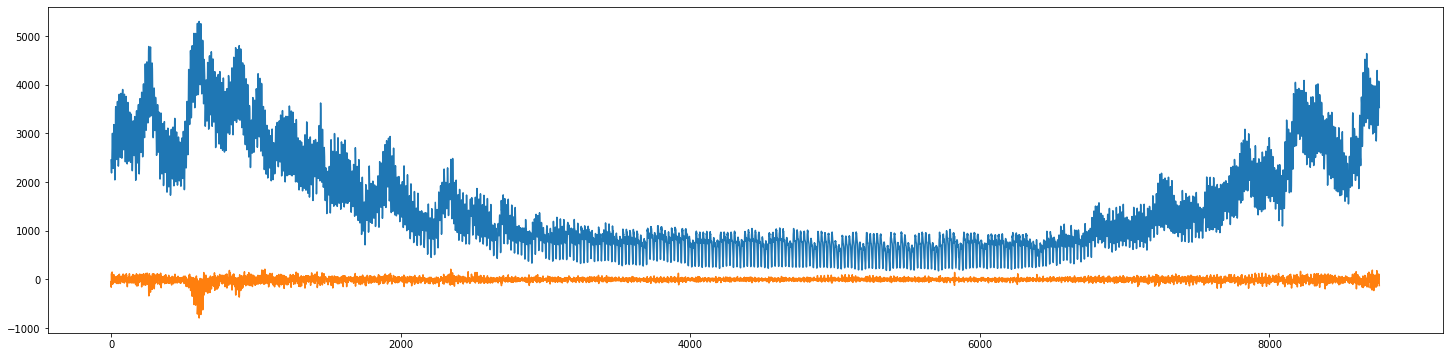

In [2]:
test_4 = test[test['구분'].isin([4])]  # for '구분' E
test_4_x = test_4[features]
test_4_y = test_4['공급량']
y_pred_4 = model.predict(test_4_x)
plt.figure(figsize=(25, 6))
test_4_y_np = test_4_y.to_numpy()
diff = y_pred_4 - test_4_y_np
plt.plot(test_4_y_np)
plt.plot(diff)